In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

# 15 Minutes

In [16]:
test15=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/15min/test_no_rr.tsv.gz',
                      sep='\t')
xval15=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/15min/xval_no_rr.tsv.gz',
                      sep='\t')

predict_test15=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_15min_test.txt',
                   header = None)
predict_xval15=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_15min_xval.txt',
                   header=None)

In [17]:
test15.rte.nunique()

163

In [18]:
# add predictions column to data frame
test15['ons_predicted'] = predict_test15
xval15['ons_predicted'] = predict_xval15
# create a column for the difference between the actual ons and predicted ons
test15['diff_ons_predicted']=test15['ons']-test15['ons_predicted']
xval15['diff_ons_predicted']=xval15['ons']-xval15['ons_predicted']

In [19]:
test15.columns,xval15.columns

(Index(['opd_date', 'trip_start_hr_15', 'rte', 'dir', 'day_of_week', 'is_ns',
        'is_rapid', 'is_weekend', 'orca_total', 'frac_disabled', 'frac_youth',
        'frac_senior', 'frac_li', 'frac_uw', 'ons', 'region', 'start', 'end',
        'type', 'summer', 'ons_predicted', 'diff_ons_predicted'],
       dtype='object'),
 Index(['opd_date', 'trip_start_hr_15', 'rte', 'dir', 'day_of_week', 'is_ns',
        'is_rapid', 'is_weekend', 'orca_total', 'frac_disabled', 'frac_youth',
        'frac_senior', 'frac_li', 'frac_uw', 'ons', 'region', 'start', 'end',
        'type', 'summer', 'ons_predicted', 'diff_ons_predicted'],
       dtype='object'))

## Test Set

In [20]:
# get sum by date
count_by_date_test_15 = test15.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_test_15['opd_date'] =pd.to_datetime(count_by_date_test_15['opd_date'])
count_by_date_test_15['dayofweek'] = count_by_date_test_15['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_test_15 = count_by_date_test_15.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_test_15

dayofweek       ons                                   ons_predicted  \
                  sum          mean          std count            sum   
0         0  363171.0  24211.400000  4050.909736    15  343550.998672   
1         1  386452.0  25763.466667  1347.898622    15  370519.431466   
2         2  400520.0  25032.500000  1780.542651    16  383313.372754   
3         3  383467.0  23966.687500  4038.685623    16  365015.188103   
4         4  364829.0  22801.812500  1987.550627    16  352112.630620   
5         5  131966.0   8247.875000  1021.790186    16  128992.601876   
6         6   95341.0   6810.071429   887.245475    14   92210.597045   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  22903.399911  3302.904587    15       19620.001328  1308.000089   
1  24701.295431  1336.209028    15       15932.568534  1062.171236   
2  23957.085797  1849.822273    16       17206.627246  1075.414203   
3  22813.449256  3543.647385    16       18451.811897  1153.238244   
4  22007.039414  1692.910509    16       12716.369380   794.773086   
5   8062.037617   882.971785    16        2973.398124   185.837383   
6   6586.471218   756.951701    14        3130.402955   223.600211   

                     
          std count  
0  858.032360    15  
1  488.546872    15  
2  549.649425    16  
3  708.463914    16  
4  549.442251    16  
5  192.419485    16  
6  184.752585    14

In [21]:
# Make plots...
def plot_by_day(acutal_mean, actual_errors, predicted_means, predicted_errors, dataset_name):
    
    labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    x_pos = np.arange(len(labels))
    width = .4

    # Build the plot
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.style.use('seaborn')
    
    acutal = ax.bar(x_pos - width/2, acutal_mean,
            yerr=actual_errors,
            width = width,
            align='center',
            ecolor='black',
            capsize=4,
            label = 'Actual')

    predicted = ax.bar(x_pos+width/2, predicted_means,
            yerr=predicted_errors,
            align='center',
            ecolor='black',
            capsize=4,
            width = width,
            label = 'Predicted')

    ax.set_ylabel('Passenger Count')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)

    plt.suptitle('Predicted vs Actual Average Ridership by Day', y=1, fontsize=18)
    plt.title(dataset_name, fontsize=14)
    

    # Save the figure and show
    ax.legend()
    plt.savefig(dataset_name +'.png')
    plt.show()

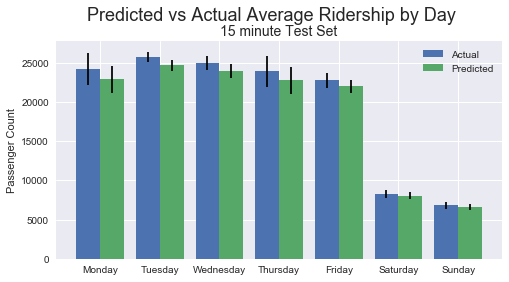

In [22]:
counts_by_day_test_15 = avg_passenger_count_by_day_test_15.ons['count']

ons_by_day_test_15 = avg_passenger_count_by_day_test_15.ons['mean']
ons_std_test_15 = avg_passenger_count_by_day_test_15.ons['std']
ons_error_test_15 = 1.96*ons_std_test_15/np.sqrt(counts_by_day_test_15)

predictions_by_day_test_15 = avg_passenger_count_by_day_test_15.ons_predicted['mean']
predictions_std_test_15 = avg_passenger_count_by_day_test_15.ons_predicted['std']
predictions_error_test_15 = 1.96*predictions_std_test_15/np.sqrt(counts_by_day_test_15)

plot_by_day(ons_by_day_test_15, ons_error_test_15,
            predictions_by_day_test_15, predictions_error_test_15,
            '15 minute Test Set')

## Validation Set

In [23]:
# get sum by date
count_by_date_xval_15 = xval15.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_xval_15['opd_date'] =pd.to_datetime(count_by_date_xval_15['opd_date'])
count_by_date_xval_15['dayofweek'] = count_by_date_xval_15['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_xval_15 = count_by_date_xval_15.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_xval_15

dayofweek       ons                                   ons_predicted  \
                  sum          mean          std count            sum   
0         0  351025.0  23401.666667  4007.905753    15  334328.836611   
1         1  375505.0  25033.666667  1343.135387    15  359576.317758   
2         2  417719.0  26107.437500  1502.662081    16  399954.323874   
3         3  388514.0  24282.125000  4351.067484    16  369911.307756   
4         4  375020.0  23438.750000  1947.044889    16  361102.723839   
5         5  132198.0   8262.375000   827.873249    16  129375.311224   
6         6   91090.0   6506.428571   779.299460    14   87781.407628   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  22288.589107  3239.792807    15       16696.163389  1113.077559   
1  23971.754517  1489.801972    15       15928.682242  1061.912149   
2  24997.145242  1569.926905    16       17764.676126  1110.292258   
3  23119.456735  3899.655663    16       18602.692244  1162.668265   
4  22568.920240  1763.764312    16       13917.276161   869.829760   
5   8085.956952   695.992687    16        2822.688776   176.418048   
6   6270.100545   632.995670    14        3308.592372   236.328027   

                     
          std count  
0  875.638667    15  
1  377.323679    15  
2  591.464109    16  
3  663.941884    16  
4  559.547563    16  
5  234.690124    16  
6  182.887558    14

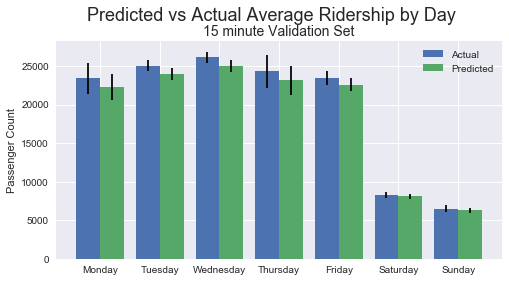

In [24]:
counts_by_day_xval_15 = avg_passenger_count_by_day_xval_15.ons['count']

ons_by_day_xval_15 = avg_passenger_count_by_day_xval_15.ons['mean']
ons_std_xval_15 = avg_passenger_count_by_day_xval_15.ons['std']
ons_error_xval_15 = 1.96*ons_std_xval_15/np.sqrt(counts_by_day_xval_15)

predictions_by_day_xval_15 = avg_passenger_count_by_day_xval_15.ons_predicted['mean']
predictions_std_xval_15 = avg_passenger_count_by_day_xval_15.ons_predicted['std']
predictions_error_xval_15 = 1.96*predictions_std_xval_15/np.sqrt(counts_by_day_xval_15)

plot_by_day(ons_by_day_xval_15, ons_error_xval_15,
            predictions_by_day_xval_15, predictions_error_xval_15,
            '15 minute Validation Set')

## Histograms of diff_ons_predicted by day

In [25]:
#test15.diff_ons_predicted[test15['day_of_week'] ==0].hist(bins = 100)

# 30 Minutes

In [26]:
test30=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/30min/test_no_rr.tsv.gz',
                      sep='\t')
xval30=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/30min/xval_no_rr.tsv.gz',
                      sep='\t')

predict_test30=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_30min_test.txt',
                   header=None)
predict_xval30=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_30min_xval.txt',
                   header=None)

In [27]:
# add predictions column to data frame
test30['ons_predicted'] = predict_test30
xval30['ons_predicted'] = predict_xval30
# create a column for the difference between the actual ons and predicted ons
test30['diff_ons_predicted']=test30['ons']-test30['ons_predicted']
xval30['diff_ons_predicted']=xval30['ons']-xval30['ons_predicted']

## Test Set

In [28]:
# get sum by date
count_by_date_test_30 = test30.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_test_30['opd_date'] =pd.to_datetime(count_by_date_test_30['opd_date'])
count_by_date_test_30['dayofweek'] = count_by_date_test_30['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_test_30 = count_by_date_test_30.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_test_30

dayofweek       ons                                   ons_predicted  \
                  sum          mean          std count            sum   
0         0  351858.0  23457.200000  3882.322412    15  335975.343023   
1         1  387130.0  25808.666667  2336.873848    15  370102.718667   
2         2  402099.0  25131.187500  2085.573182    16  382860.602717   
3         3  388692.0  24293.250000  4039.969183    16  367889.952822   
4         4  375654.0  23478.375000  2188.070806    16  356698.985518   
5         5  135272.0   8454.500000  1175.787793    16  126512.429846   
6         6   91868.0   6562.000000   810.695048    14   86389.096731   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  22398.356202  3177.208209    15       15882.656977  1058.843798   
1  24673.514578  2218.669712    15       17027.281333  1135.152089   
2  23928.787670  2079.355256    16       19238.397283  1202.399830   
3  22993.122051  3570.404796    16       20802.047178  1300.127949   
4  22293.686595  1887.612299    16       18955.014482  1184.688405   
5   7907.026865   974.144878    16        8759.570154   547.473135   
6   6170.649767   686.218475    14        5478.903269   391.350233   

                     
          std count  
0  763.591204    15  
1  475.308084    15  
2  245.988156    16  
3  862.539190    16  
4  743.573441    16  
5  288.735849    16  
6  200.815536    14

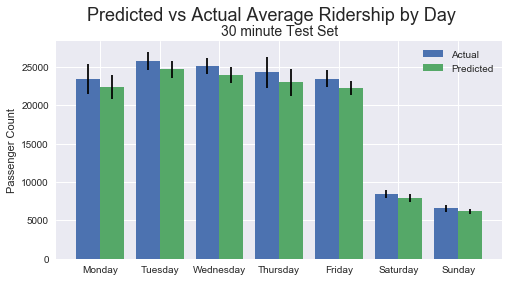

In [29]:
counts_by_day_test_30 = avg_passenger_count_by_day_test_30.ons['count']

ons_by_day_test_30 = avg_passenger_count_by_day_test_30.ons['mean']
ons_std_test_30 = avg_passenger_count_by_day_test_30.ons['std']
ons_error_test_30 = 1.96*ons_std_test_30/np.sqrt(counts_by_day_test_30)

predictions_by_day_test_30 = avg_passenger_count_by_day_test_30.ons_predicted['mean']
predictions_std_test_30 = avg_passenger_count_by_day_test_30.ons_predicted['std']
predictions_error_test_30 = 1.96*predictions_std_test_30/np.sqrt(counts_by_day_test_30)

plot_by_day(ons_by_day_test_30, ons_error_test_30,
            predictions_by_day_test_30, predictions_error_test_30,
            '30 minute Test Set')

# Validation Set

In [30]:
# get sum by date
count_by_date_xval_30 = xval30.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_xval_30['opd_date'] =pd.to_datetime(count_by_date_xval_30['opd_date'])
count_by_date_xval_30['dayofweek'] = count_by_date_xval_30['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_xval_30 = count_by_date_xval_30.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_xval_30

dayofweek       ons                                   ons_predicted  \
                  sum          mean          std count            sum   
0         0  359523.0  23968.200000  3857.071506    15  344206.497618   
1         1  387240.0  25816.000000  1010.926237    15  369999.362960   
2         2  398759.0  24922.437500  1762.583028    16  378806.084669   
3         3  395408.0  24713.000000  4613.155363    16  374880.307179   
4         4  375892.0  23493.250000  2305.915885    16  357349.227133   
5         5  136417.0   8526.062500   705.467171    16  127484.957149   
6         6   90102.0   6435.857143   804.890232    14   84799.575002   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  22947.099841  3235.876042    15       15316.502382  1021.100159   
1  24666.624197  1120.076544    15       17240.637040  1149.375803   
2  23675.380292  1848.507074    16       19952.915331  1247.057208   
3  23430.019199  4128.598660    16       20527.692821  1282.980801   
4  22334.326696  2047.591439    16       18542.772867  1158.923304   
5   7967.809822   639.775700    16        8932.042851   558.252678   
6   6057.112500   689.045894    14        5302.424998   378.744643   

                     
          std count  
0  871.249027    15  
1  344.165314    15  
2  513.808616    16  
3  823.072476    16  
4  563.827936    16  
5  208.908624    16  
6  201.320352    14

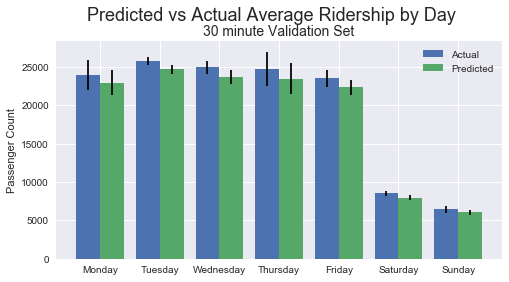

In [31]:
counts_by_day_xval_30 = avg_passenger_count_by_day_xval_30.ons['count']

ons_by_day_xval_30 = avg_passenger_count_by_day_xval_30.ons['mean']
ons_std_xval_30 = avg_passenger_count_by_day_xval_30.ons['std']
ons_error_xval_30 = 1.96*ons_std_xval_30/np.sqrt(counts_by_day_xval_30)

predictions_by_day_xval_30 = avg_passenger_count_by_day_xval_30.ons_predicted['mean']
predictions_std_xval_30 = avg_passenger_count_by_day_xval_30.ons_predicted['std']
predictions_error_xval_30 = 1.96*predictions_std_xval_30/np.sqrt(counts_by_day_xval_30)

plot_by_day(ons_by_day_xval_30, ons_error_xval_30,
            predictions_by_day_xval_30, predictions_error_xval_30,
            '30 minute Validation Set')

# 1 Hour

In [32]:
testHr=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/hr/test.tsv.gz',
                      sep='\t')
xvalHr=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/hr/xval.tsv.gz',
                      sep='\t')

predict_test_hr=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_hr_test.txt',
                   header=None)
predict_xval_hr=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_hr_xval.txt',
                   header=None)

In [33]:
# add predictions column to data frame
testHr['ons_predicted'] = predict_test_hr
xvalHr['ons_predicted'] = predict_xval_hr
# create a column for the difference between the actual ons and predicted ons
testHr['diff_ons_predicted']=testHr['ons']-testHr['ons_predicted']
xvalHr['diff_ons_predicted']=xvalHr['ons']-xvalHr['ons_predicted']

## Test Set

In [34]:
# get sum by date
count_by_date_test_hr = testHr.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_test_hr['opd_date'] =pd.to_datetime(count_by_date_test_hr['opd_date'])
count_by_date_test_hr['dayofweek'] = count_by_date_test_hr['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_test_hr = count_by_date_test_hr.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_test_hr

dayofweek       ons                                 ons_predicted  \
                  sum        mean          std count            sum   
0         0  437088.0  29139.2000  3920.409949    15  320724.877622   
1         1  473643.0  31576.2000  2711.924414    15  351457.003420   
2         2  488618.0  30538.6250  2755.537283    16  378271.132352   
3         3  469008.0  29313.0000  5282.860955    16  346987.731934   
4         4  456793.0  28549.5625  2735.007763    16  321006.254616   
5         5  178036.0  11127.2500  1301.123643    16  216223.110863   
6         6  127421.0   9101.5000  1369.902565    14  187091.142668   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  21381.658508  7944.220480    15       87847.122378  5856.474825   
1  23430.466895  8535.631922    15       93051.996580  6203.466439   
2  23641.945772  8338.374350    16       79684.867648  4980.304228   
3  21686.733246  7348.884516    16       95041.268066  5940.079254   
4  20062.890914  9159.781274    16       91475.745384  5717.234086   
5  13513.944429  7096.539867    16      -61272.110863 -3829.506929   
6  13363.653048  5301.866888    14      -67926.142668 -4851.867333   

                      
           std count  
0  7316.490210    15  
1  6227.480227    15  
2  5606.957851    16  
3  7311.382661    16  
4  6781.428114    16  
5  4781.667476    16  
6  4207.849112    14

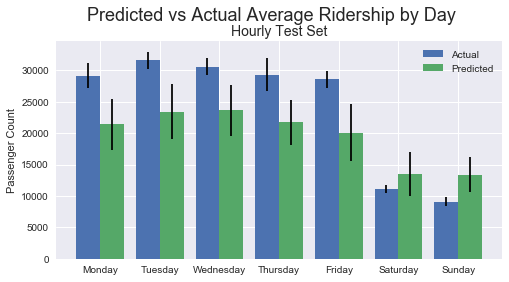

In [35]:
counts_by_day_test_hr = avg_passenger_count_by_day_test_hr.ons['count']

ons_by_day_test_hr = avg_passenger_count_by_day_test_hr.ons['mean']
ons_std_test_hr = avg_passenger_count_by_day_test_hr.ons['std']
ons_error_test_hr = 1.96*ons_std_test_hr/np.sqrt(counts_by_day_test_hr)

predictions_by_day_test_hr = avg_passenger_count_by_day_test_hr.ons_predicted['mean']
predictions_std_test_hr = avg_passenger_count_by_day_test_hr.ons_predicted['std']
predictions_error_test_hr = 1.96*predictions_std_test_hr/np.sqrt(counts_by_day_test_hr)

plot_by_day(ons_by_day_test_hr, ons_error_test_hr,
            predictions_by_day_test_hr, predictions_error_test_hr,
            'Hourly Test Set')

## Validation Set

In [36]:
# get sum by date
count_by_date_xval_hr = xvalHr.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_xval_hr['opd_date'] =pd.to_datetime(count_by_date_xval_hr['opd_date'])
count_by_date_xval_hr['dayofweek'] = count_by_date_xval_hr['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_xval_hr = count_by_date_xval_hr.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_xval_hr

dayofweek       ons                                   ons_predicted  \
                  sum          mean          std count            sum   
0         0  449110.0  29940.666667  5735.426795    15  330838.420437   
1         1  480975.0  32065.000000  3054.268301    15  341981.124352   
2         2  496690.0  31043.125000  2737.000472    16  370599.946786   
3         3  484873.0  30304.562500  5340.314747    16  358120.794780   
4         4  461787.0  28861.687500  2538.236204    16  319883.266852   
5         5  195282.0  12205.125000  1438.395721    16  224983.172919   
6         6  135226.0   9659.000000  1175.387203    14  203120.542824   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  22055.894696  8195.179546    15       87528.579563  5835.238638   
1  22798.741623  8024.880329    15      113015.875648  7534.391710   
2  23162.496674  8009.590863    16       96773.053214  6048.315826   
3  22382.549674  7949.498542    16       96931.205220  6058.200326   
4  19992.704178  8498.032843    16       96535.733148  6033.483322   
5  14061.448307  7399.621859    16      -55317.172919 -3457.323307   
6  14508.610202  5790.847665    14      -79289.542824 -5663.538773   

                      
           std count  
0  8832.646751    15  
1  6169.768130    15  
2  5928.855886    16  
3  5882.158973    16  
4  6001.046896    16  
5  5092.349531    16  
6  4793.694278    14

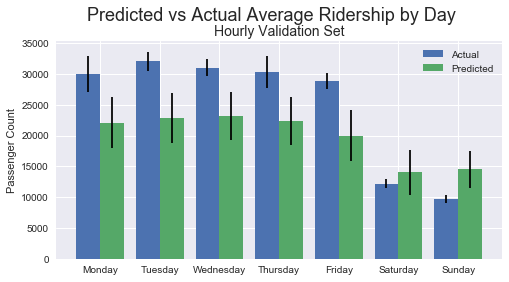

In [37]:
counts_by_day_xval_hr = avg_passenger_count_by_day_xval_hr.ons['count']

ons_by_day_xval_hr = avg_passenger_count_by_day_xval_hr.ons['mean']
ons_std_xval_hr = avg_passenger_count_by_day_xval_hr.ons['std']
ons_error_xval_hr = 1.96*ons_std_xval_hr/np.sqrt(counts_by_day_xval_hr)

predictions_by_day_xval_hr = avg_passenger_count_by_day_xval_hr.ons_predicted['mean']
predictions_std_xval_hr = avg_passenger_count_by_day_xval_hr.ons_predicted['std']
predictions_error_xval_hr = 1.96*predictions_std_xval_hr/np.sqrt(counts_by_day_xval_hr)

plot_by_day(ons_by_day_xval_hr, ons_error_xval_hr,
            predictions_by_day_xval_hr, predictions_error_xval_hr,
            'Hourly Validation Set')